---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**


----------------
## Network spanning trees
### Understanding minimum & maximum spanning trees in `spaghetti`

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook demonstrates minimum & maximum spanning trees for the following:**

1. Elementary geometric objects
2. Synthetic networks
3. An empirical example

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark

2020-03-30T11:29:21-04:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import geopandas
import libpysal
from libpysal import cg
import matplotlib
import matplotlib.pyplot as plt
import spaghetti

%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
spaghetti  1.4.2.post2
matplotlib 3.1.2
geopandas  0.7.0
libpysal   4.2.2



In [3]:
try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina")
except ImportError:
    pass

##### Helper functions for plotting and labeling

In [4]:
def plotter(net_arcs, net_verts, mst_arcs=None, mst_verts=None, label=True):
    """Convenience plotting function."""
    plot_mst, msize, vert_z = False, 40, 3
    if hasattr(mst_arcs, "T") and hasattr(mst_verts, "T"):
        plot_mst, msize, vert_z = True, 20, 4
    # set arc keyword arguments
    arc_kws = {"column":"comp_label", "cmap":"Paired"}
    # set the streets as the plot base
    base_kws = {"figsize":(12, 12)}
    base_kws.update(arc_kws)
    base = net_arcs.plot(lw=5, alpha=.9, **base_kws)
    # create vertices keyword arguments for matplotlib
    ax_kwargs = {"ax":base}
    net_verts.plot(color="k", markersize=msize, zorder=vert_z, **ax_kwargs)
    # plot spanning trees
    if plot_mst:
        mst_arcs.plot(color="k", lw=3, zorder=2, alpha=.9, **ax_kwargs)
        mst_verts.plot(color="r", markersize=100, zorder=3, **ax_kwargs)
    # label network/tree elements
    if label:
        if not plot_mst:
            arc_labels(net_arcs, base, 12)
            vert_labels(net_verts, base, 14)
        else:
            arc_labels(mst_arcs, base, 12)
            vert_labels(mst_verts, base, 14)

def arc_labels(a, b, s):
    """Label each network arc."""
    def _lab_loc(_x):
        """Helper for labeling network arcs."""
        return _x.geometry.interpolate(0.5, normalized=True).coords[0]
    kws = {"size": s, "ha": "center", "va": "bottom"}
    a.apply(lambda x: b.annotate(s=x.id, xy=_lab_loc(x), **kws), axis=1)

def vert_labels(v, b, s):
    """Label each network vertex."""
    def _lab_loc(_x):
        """Helper for labeling vertices."""
        return _x.geometry.coords[0]
    kws = {"size": s, "ha": "left", "va": "bottom", "weight": "bold"}
    v.apply(lambda x: b.annotate(s=x.id, xy=_lab_loc(x), **kws), axis=1)

---------------------
### 1. Elementary geometric objects
##### 1.a Simple cross

In [5]:
bounds = (0,0,2,2)
h, v = 1, 1
cross = spaghetti.regular_lattice(bounds, h, nv=v, exterior=False)
lines = geopandas.GeoDataFrame(geometry=cross)

In [6]:
ntw = spaghetti.Network(in_data=lines)
elem_kws = {"vertices":True, "arcs":True}
vertices, arcs = spaghetti.element_as_gdf(ntw, **elem_kws)

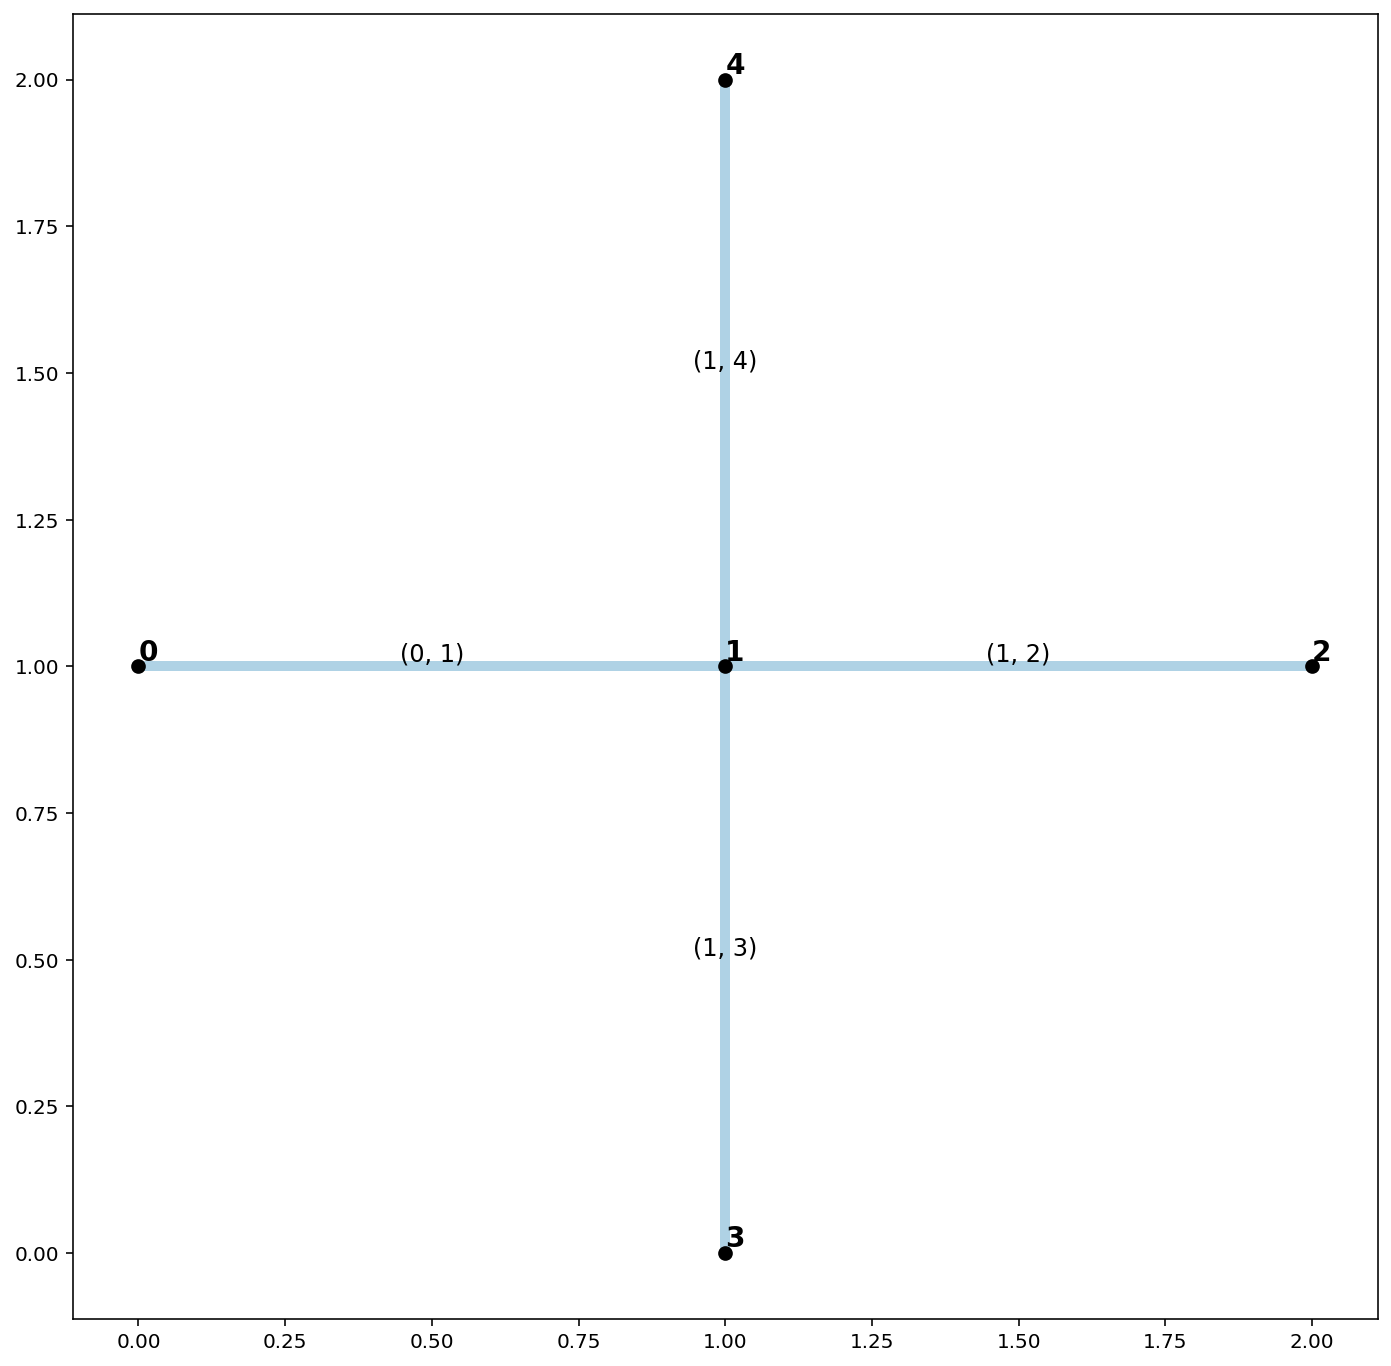

In [7]:
plotter(arcs, vertices, mst_arcs=None, mst_verts=None)

###### Minimum Spanning Tree

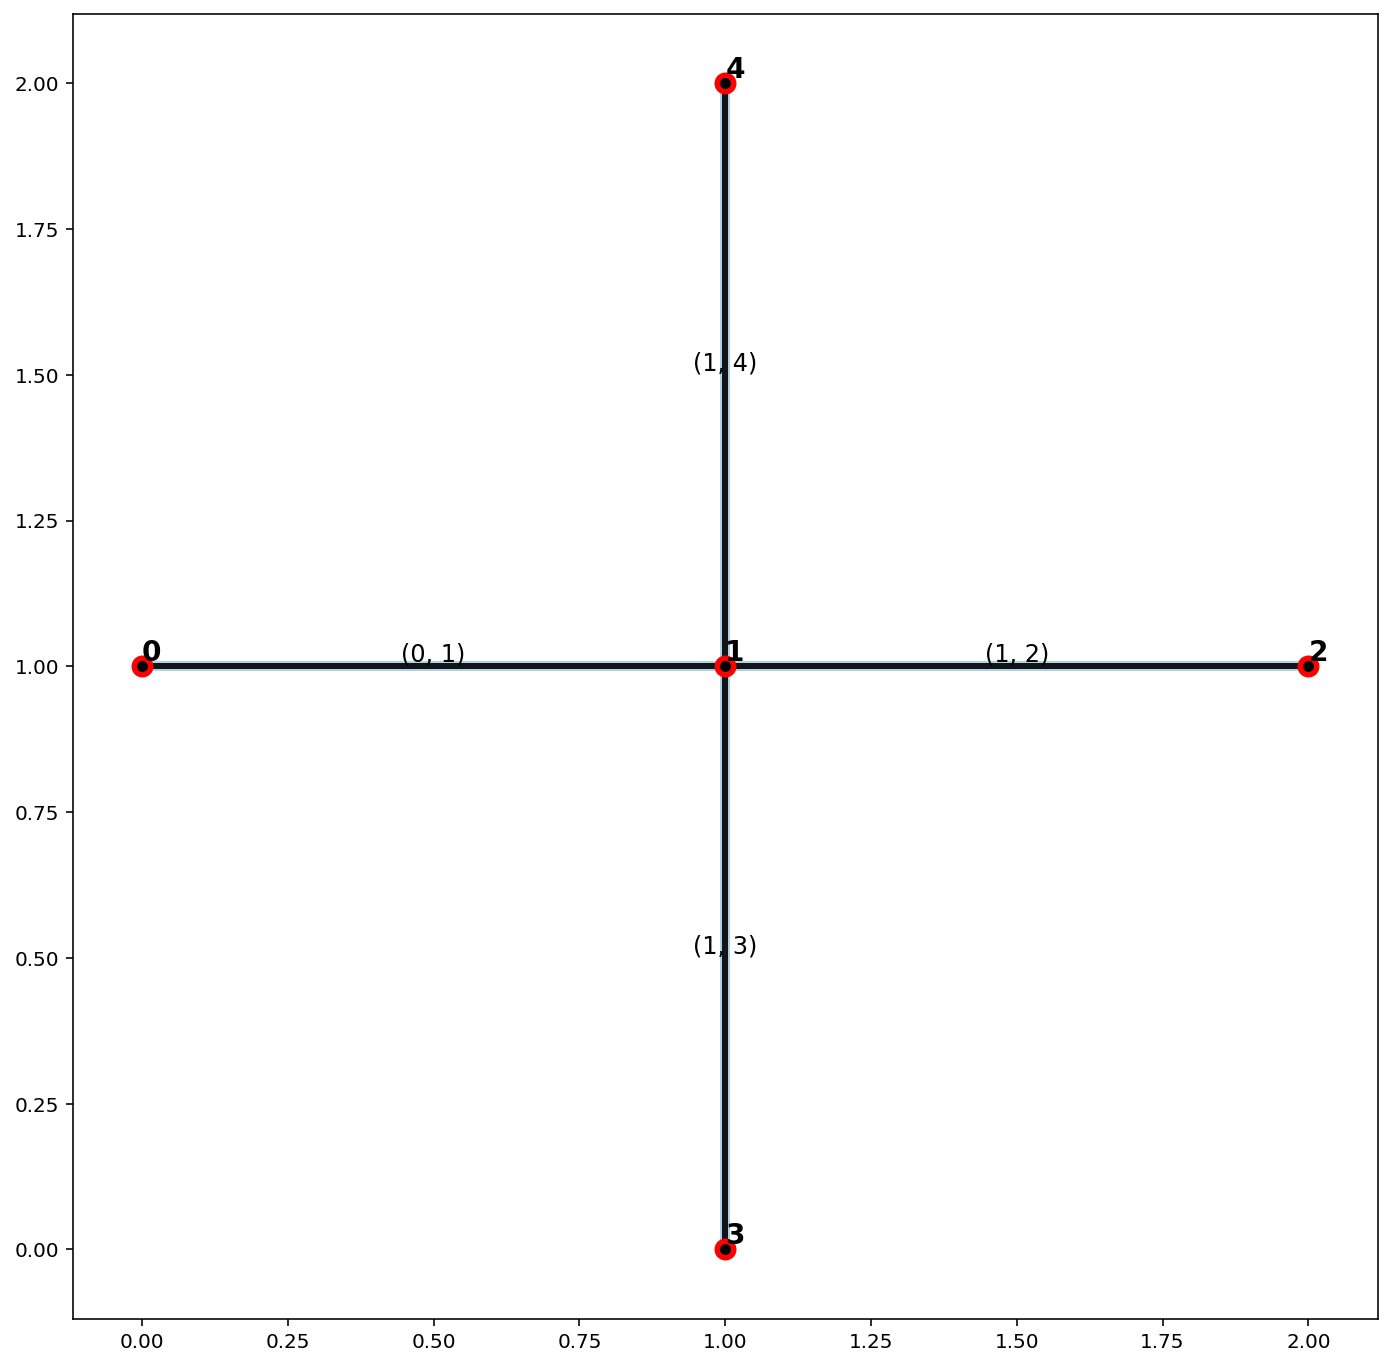

In [8]:
minst_net = spaghetti.spanning_tree(ntw)
mst_verts, mst_arcs = spaghetti.element_as_gdf(minst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts)

###### Maximum Spanning Tree

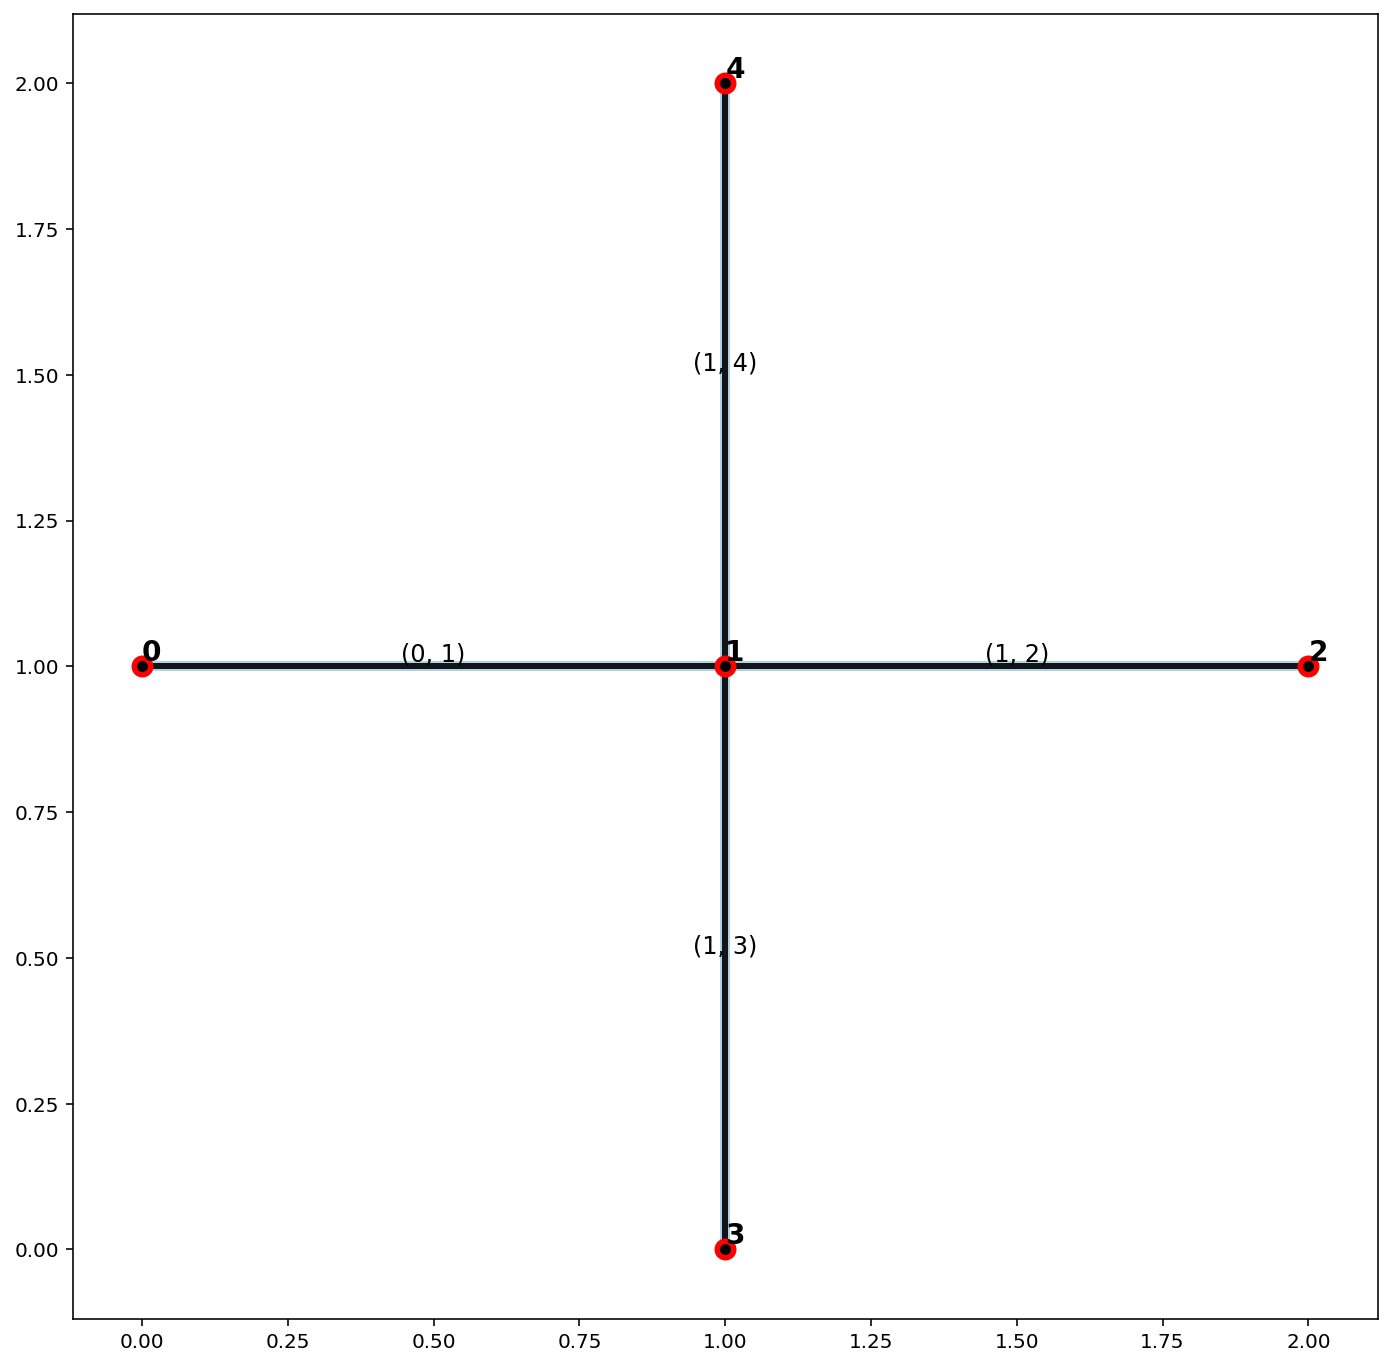

In [9]:
maxst_net = spaghetti.spanning_tree(ntw, maximum=True)
mst_verts, mst_arcs = spaghetti.element_as_gdf(maxst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts)

###### No cycles can be formed with this simple intersection. Therefore, all network arcs are both members of the minimum and maximum spanning trees.

------------------------------
##### 1.b  [Pythagorean triple triangle](https://en.wikipedia.org/wiki/Pythagorean_triple)

In [10]:
p00 = cg.Point((0,0))
lines = [cg.Chain([p00, cg.Point((0,3)), cg.Point((4,0)), p00])]

In [11]:
ntw = spaghetti.Network(in_data=lines)
elem_kws = {"vertices":True, "arcs":True}
vertices, arcs = spaghetti.element_as_gdf(ntw, **elem_kws)

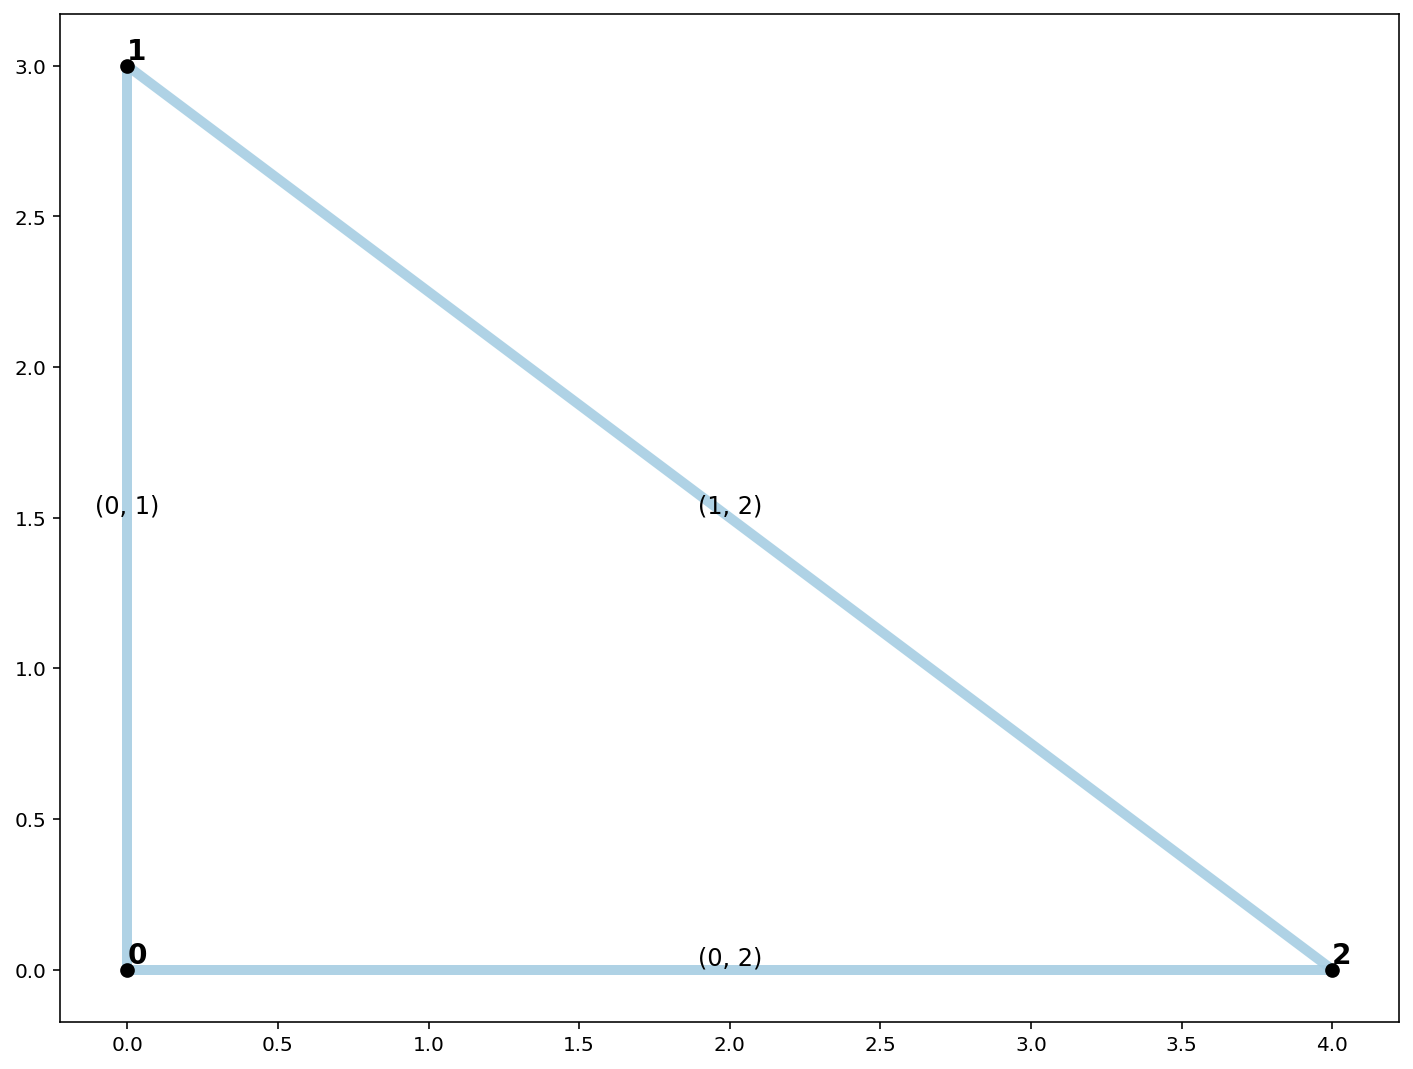

In [12]:
plotter(arcs, vertices, mst_arcs=None, mst_verts=None)

###### Minimum Spanning Tree

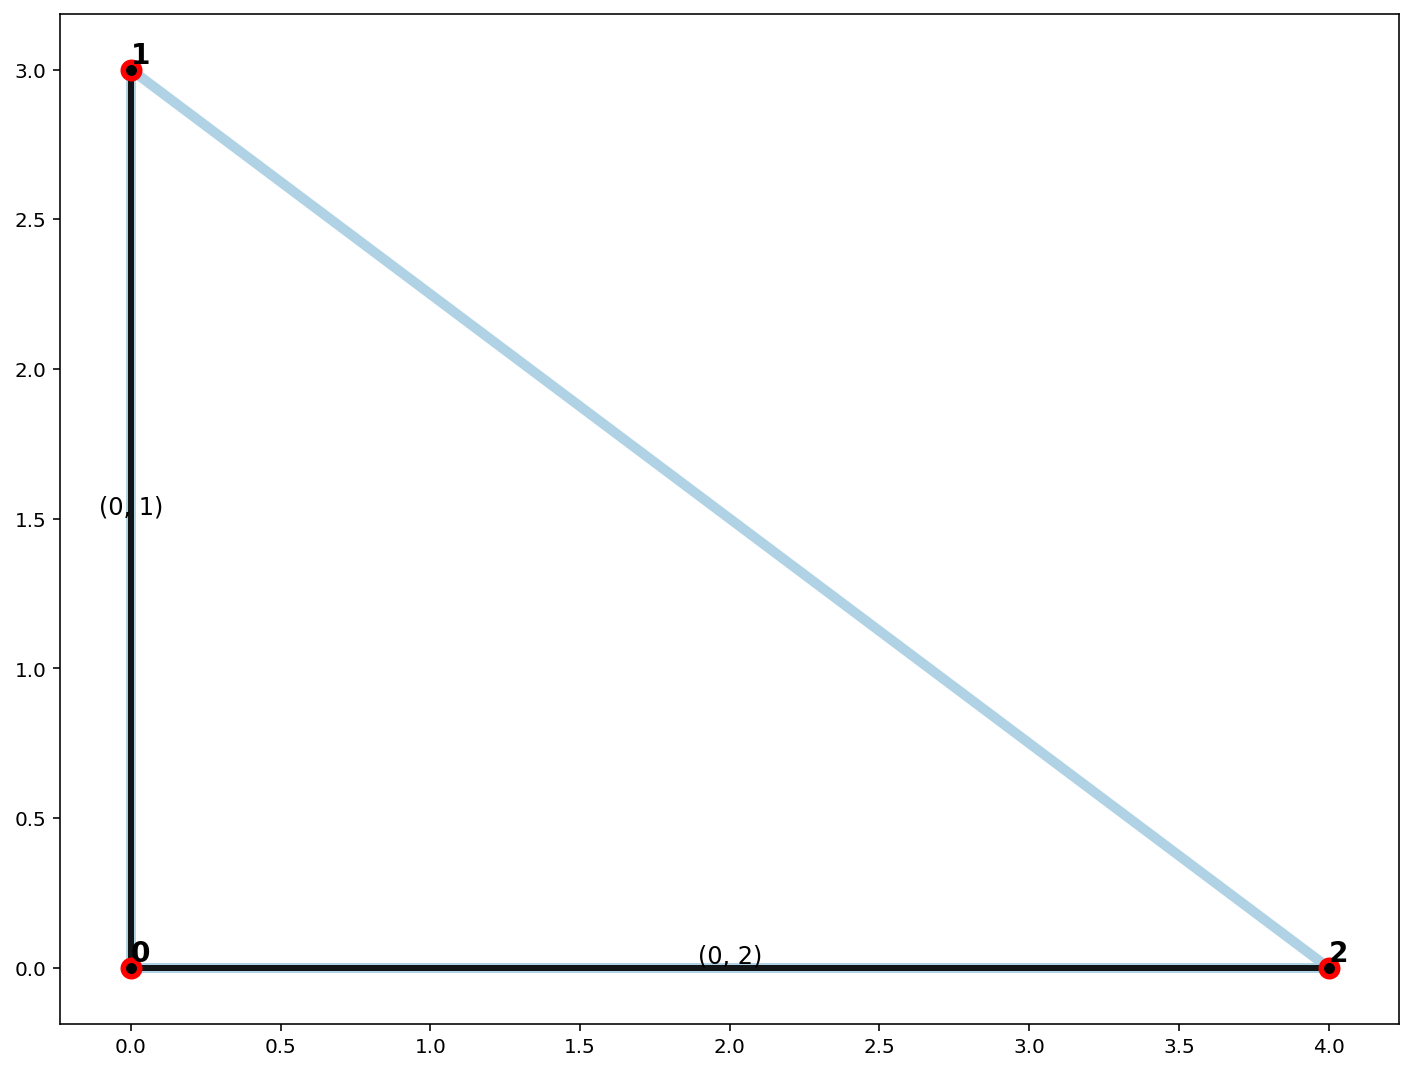

In [13]:
minst_net = spaghetti.spanning_tree(ntw)
mst_verts, mst_arcs = spaghetti.element_as_gdf(minst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts)

###### Maximum Spanning Tree

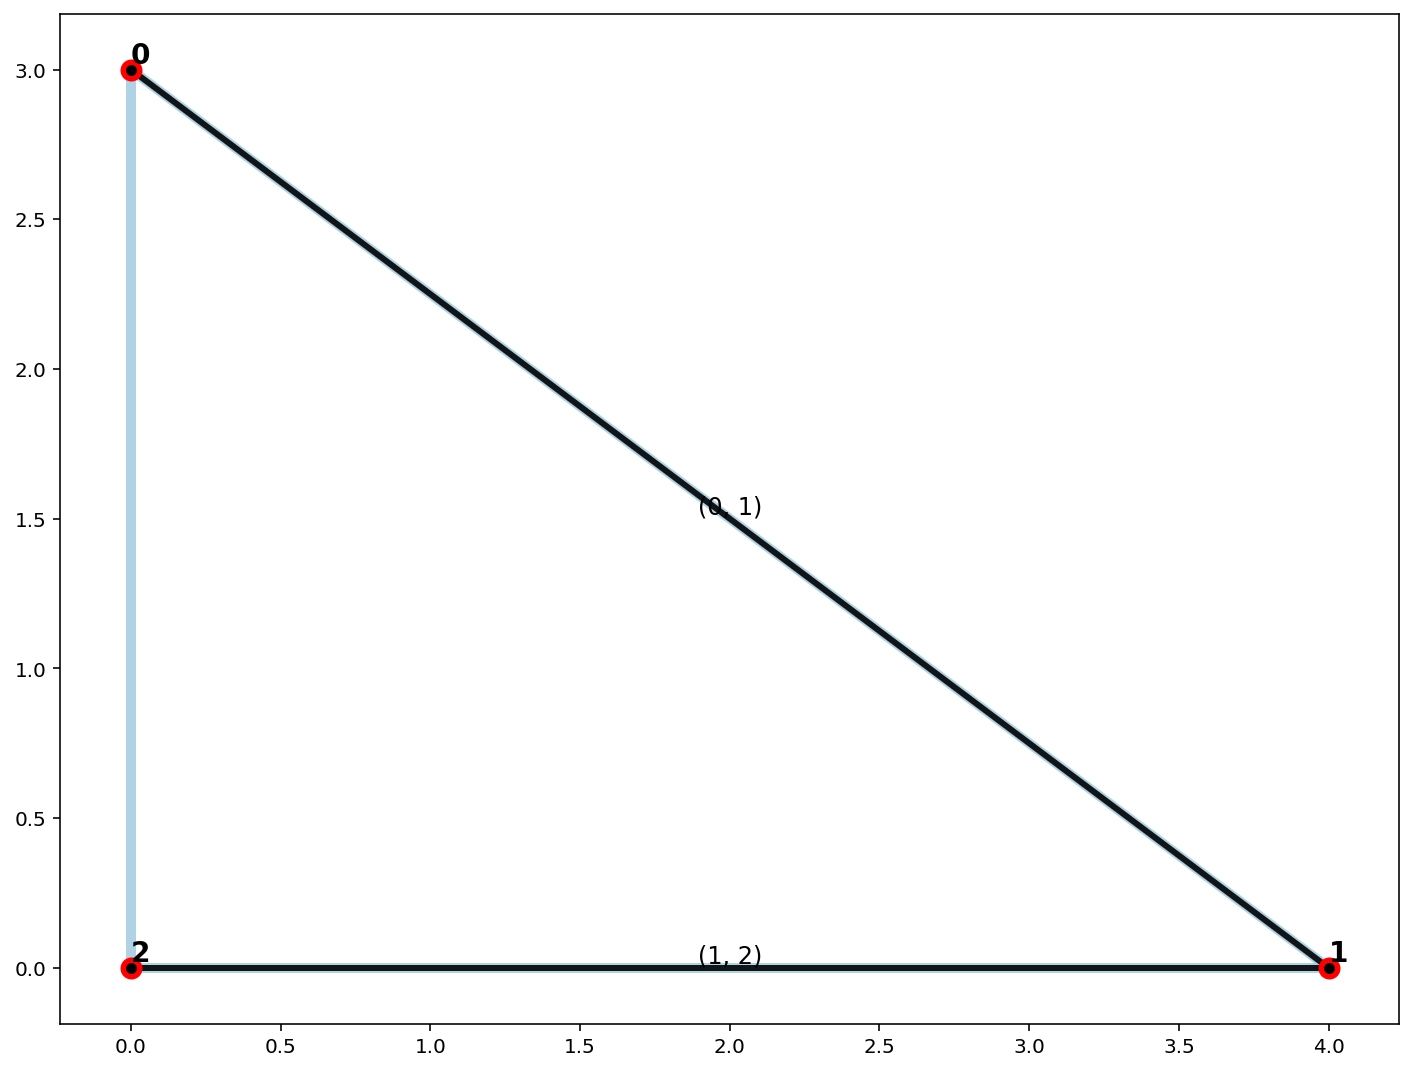

In [14]:
maxst_net = spaghetti.spanning_tree(ntw, maximum=True)
mst_verts, mst_arcs = spaghetti.element_as_gdf(maxst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts)

###### Due to the nature of a [Pythagorean triple triangle](https://en.wikipedia.org/wiki/Pythagorean_triple), it is excellent for demonstrating the most basic example of a network work cycle, and the difference between a minimum and maximum spanning tree.


---------------
### 2. Synthetic Networks
##### 2.a Inspired by Figure 3.25 in Okabe and Sugihara (2012)

In [15]:
p04, p94, p90 = cg.Point((0,4)), cg.Point((9,4)), cg.Point((9,0))
p33, p43 = cg.Point((3,3)), cg.Point((4,3))
# interior
lines = [cg.Chain([p04, p33, p00]), cg.Chain([p94, p43, p90]), cg.Chain([p33, p43])]
# exterior
lines += [cg.Chain([p00, p04, p94, p90, p00])]

In [16]:
ntw = spaghetti.Network(in_data=lines)
elem_kws = {"vertices":True, "arcs":True}
vertices, arcs = spaghetti.element_as_gdf(ntw, **elem_kws)

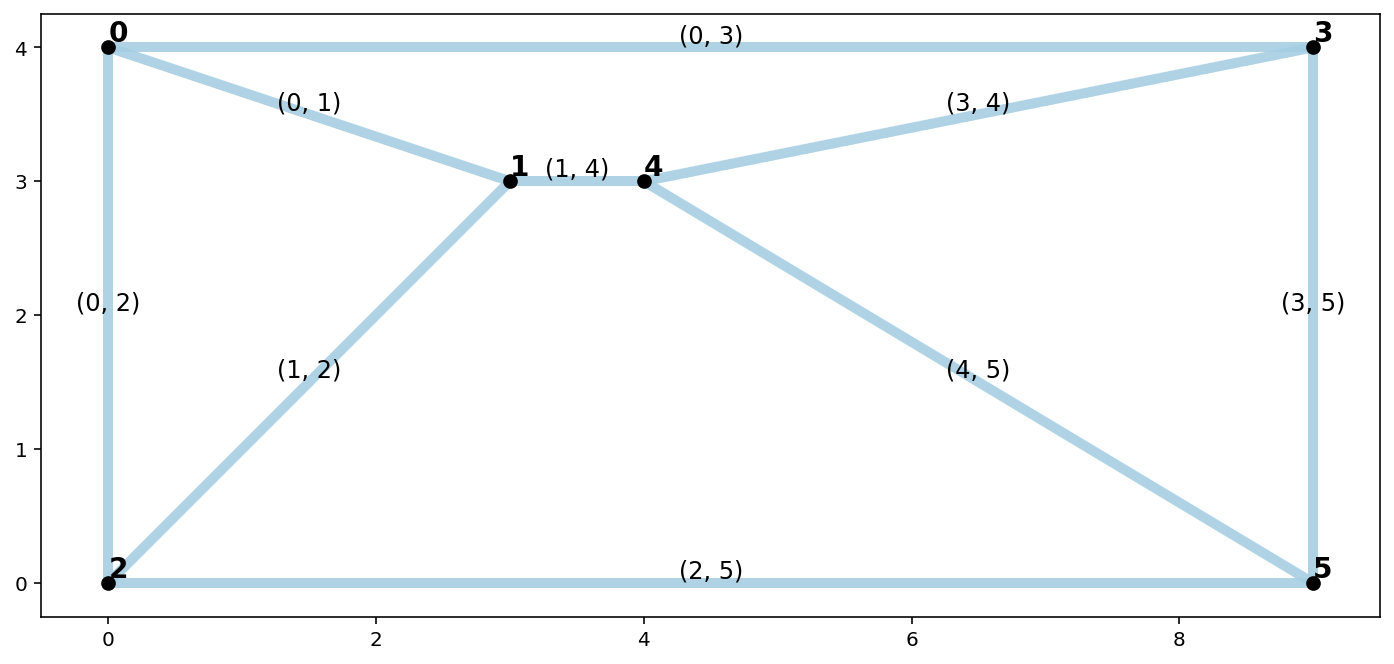

In [17]:
plotter(arcs, vertices, mst_arcs=None, mst_verts=None)

###### Minimum Spanning Tree

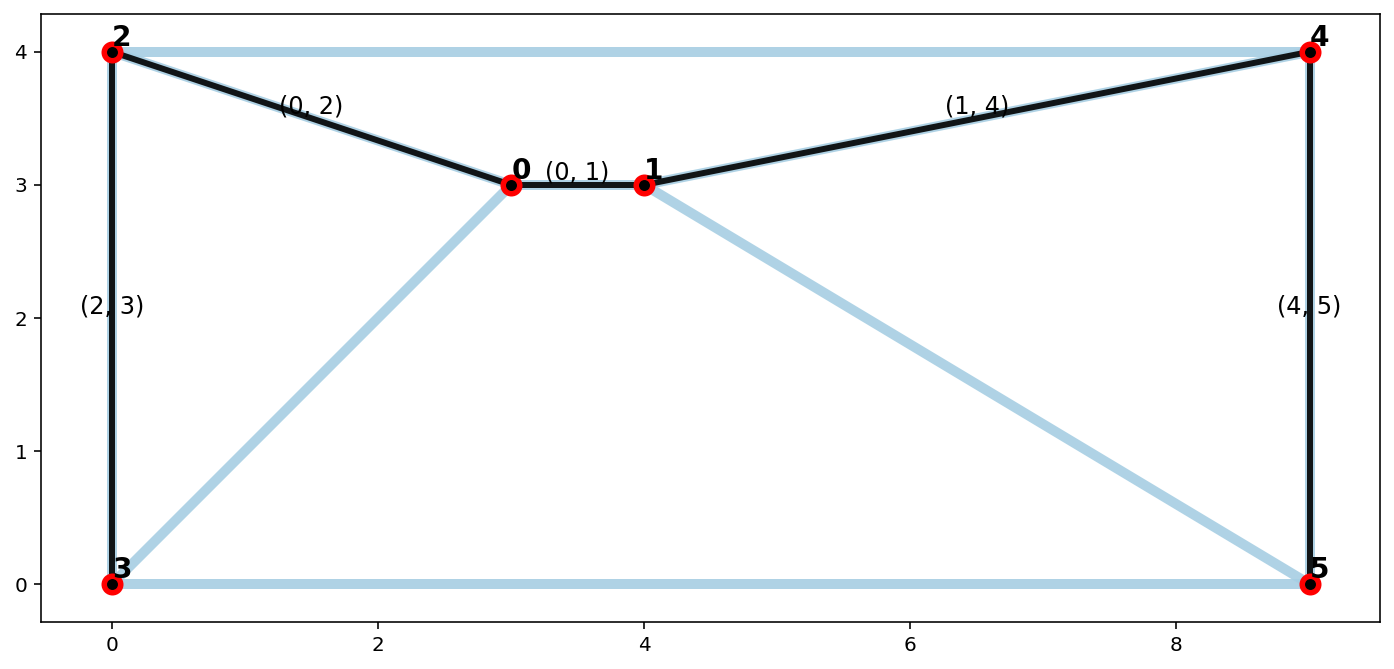

In [18]:
minst_net = spaghetti.spanning_tree(ntw)
mst_verts, mst_arcs = spaghetti.element_as_gdf(minst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts)

###### Maximum Spanning Tree

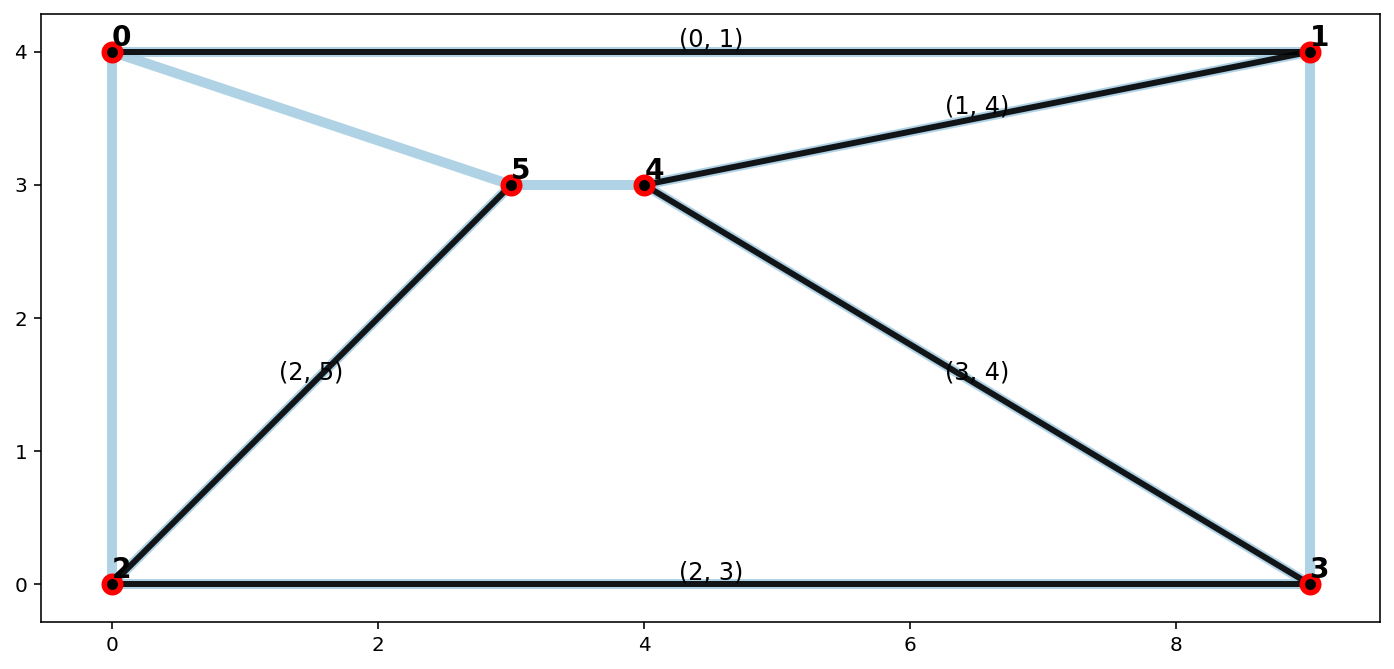

In [19]:
maxst_net = spaghetti.spanning_tree(ntw, maximum=True)
mst_verts, mst_arcs = spaghetti.element_as_gdf(maxst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts)

--------------------
##### 2.b 4x4 Regular lattice

In [20]:
bounds = (0,0,3,3)
h, v = 2, 2
lattice = spaghetti.regular_lattice(bounds, h, nv=v, exterior=True)
ntw = spaghetti.Network(in_data=lattice)
vertices, arcs = spaghetti.element_as_gdf(ntw, **elem_kws)

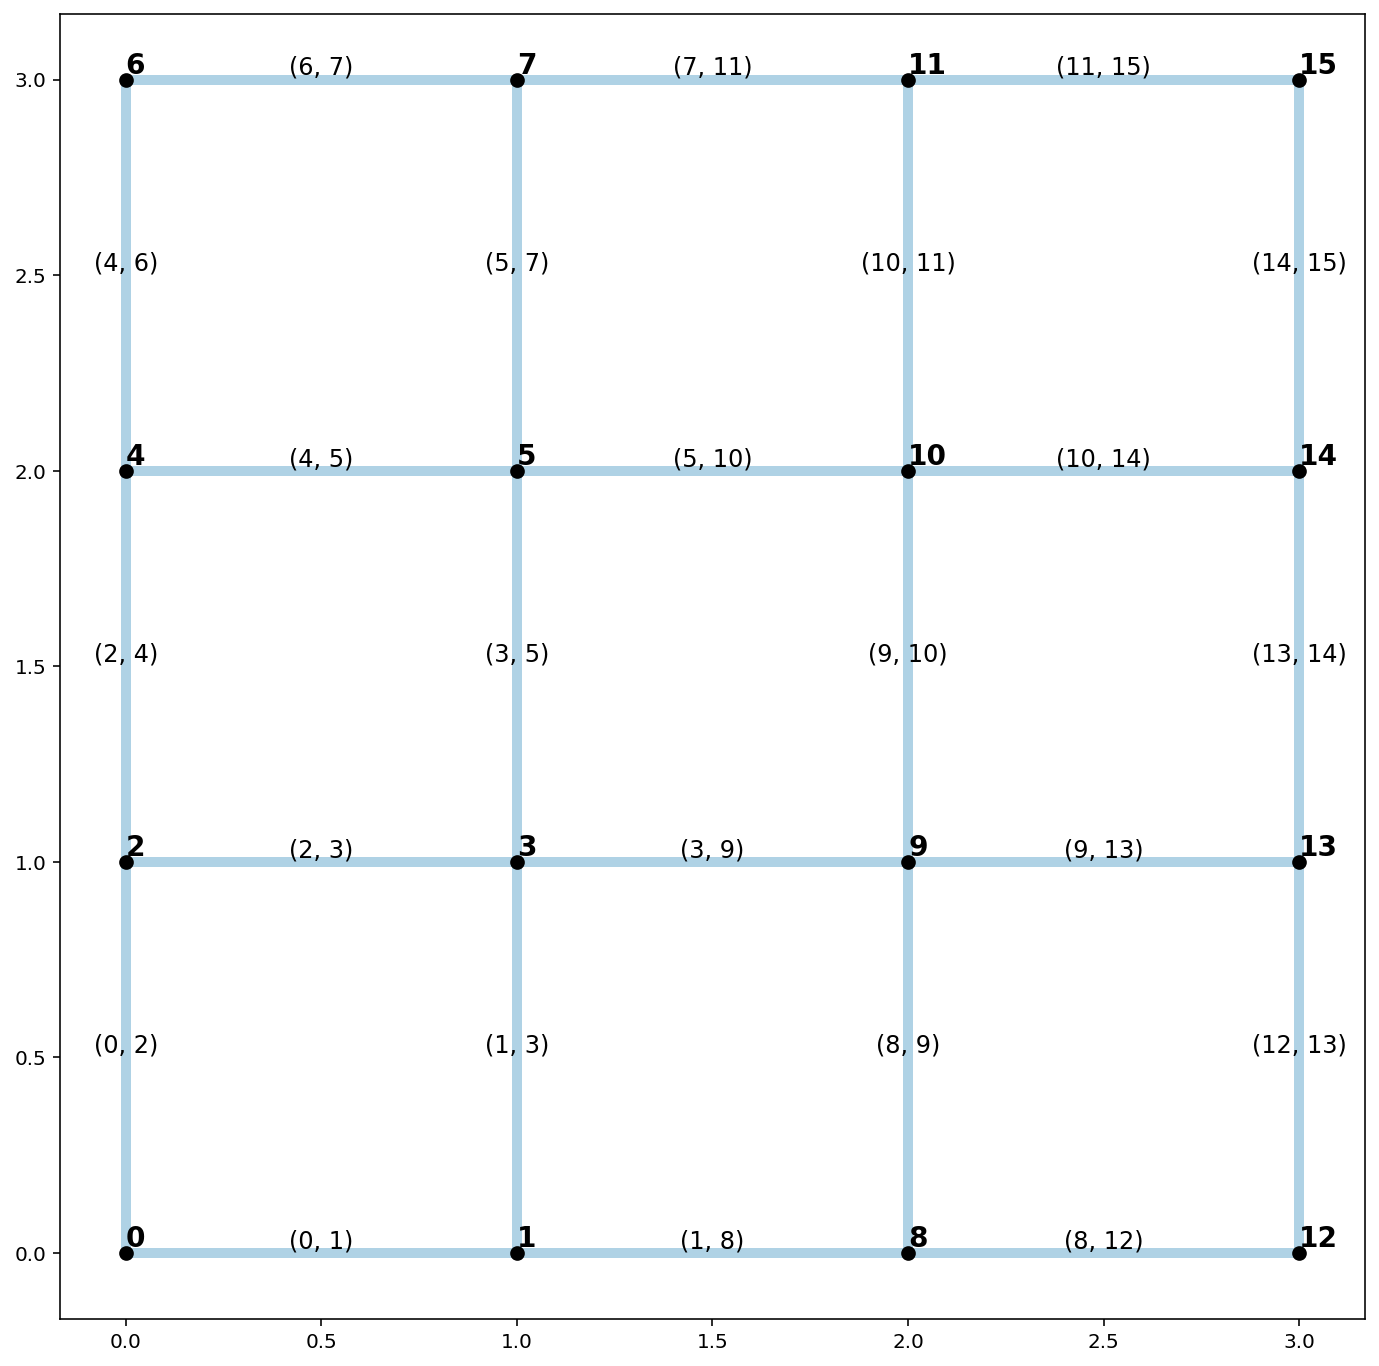

In [21]:
plotter(arcs, vertices, mst_arcs=None, mst_verts=None)

###### Minimum Spanning Tree

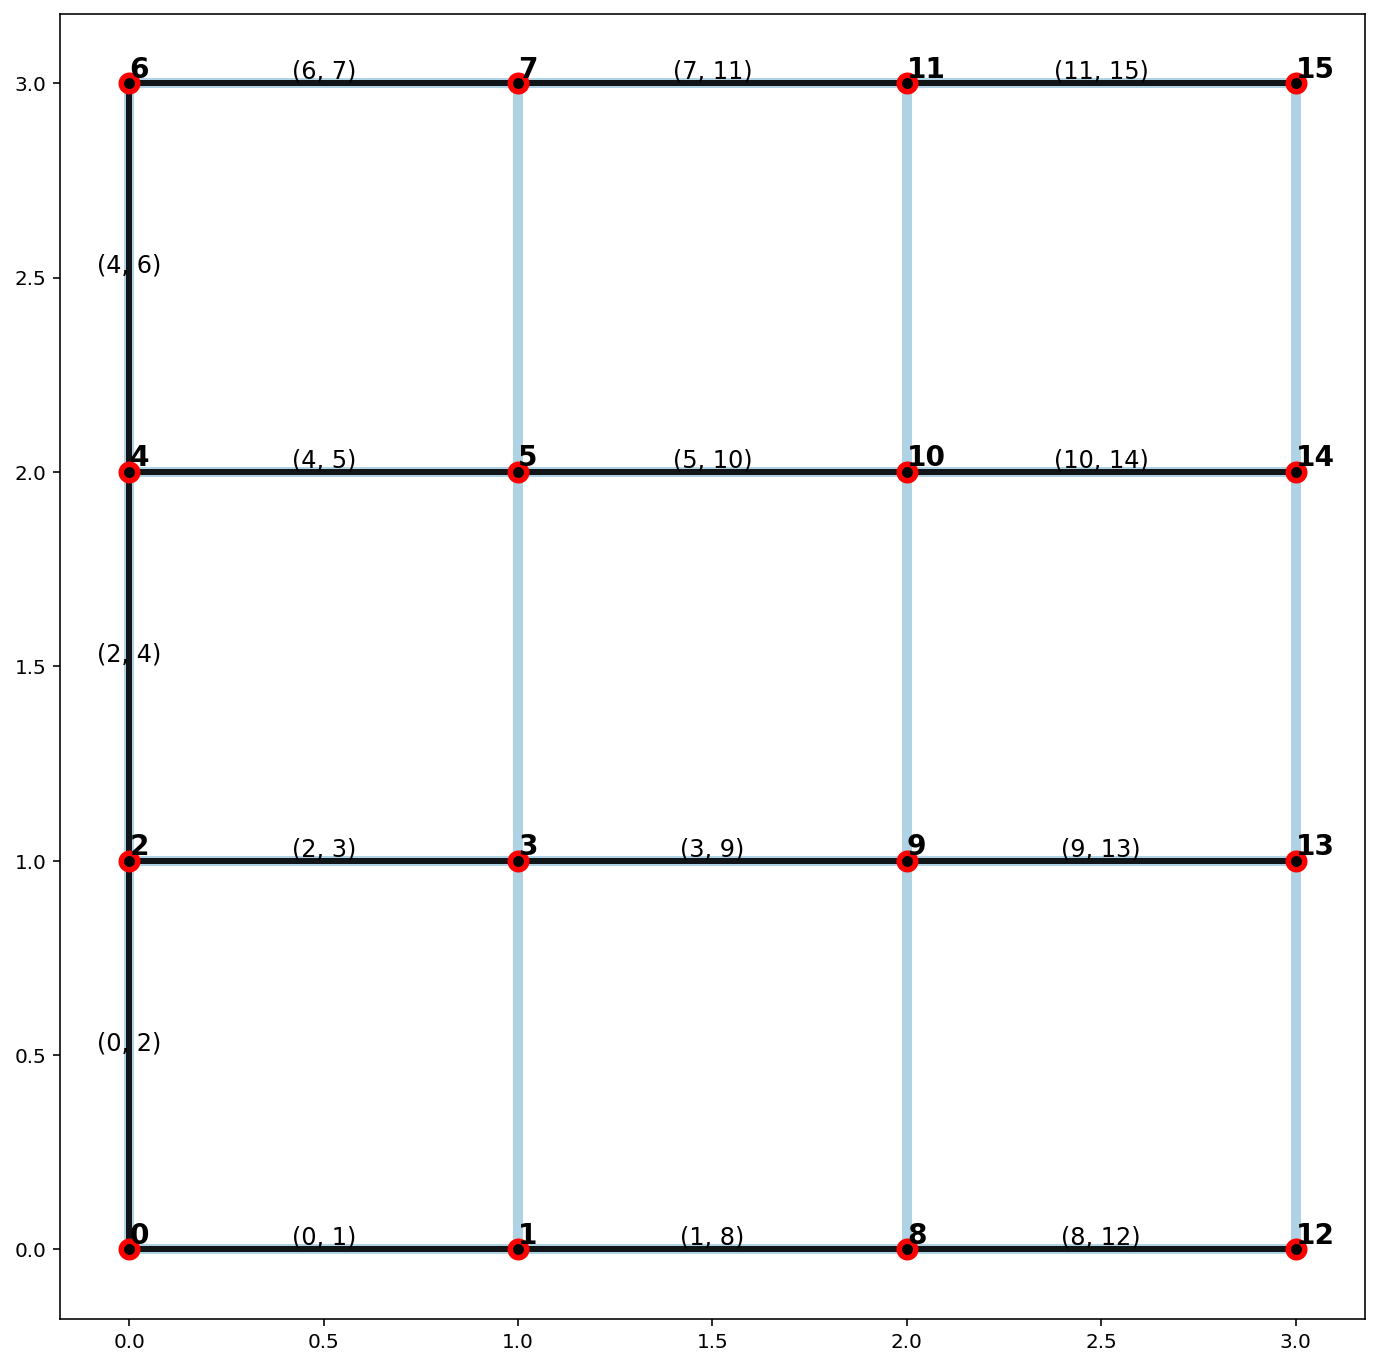

In [22]:
minst_net = spaghetti.spanning_tree(ntw, maximum=False)
mst_verts, mst_arcs = spaghetti.element_as_gdf(minst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts)

###### Maximum Spanning Tree

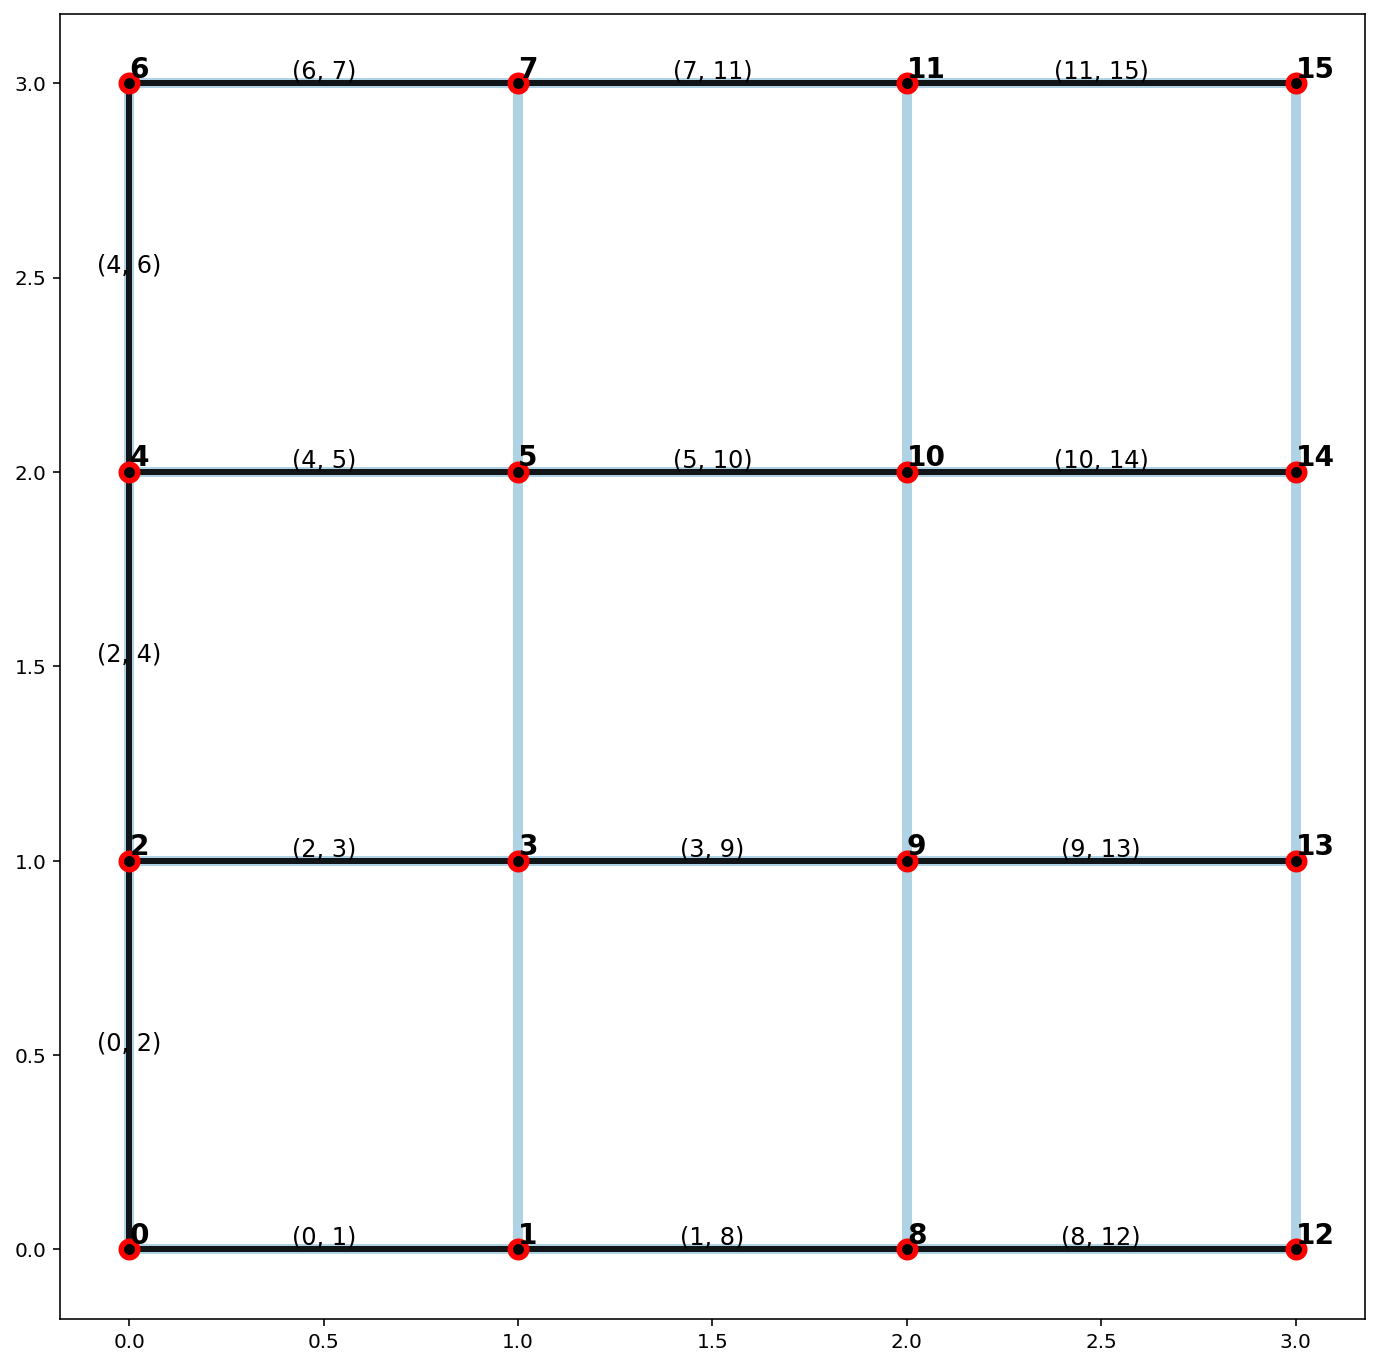

In [23]:
maxst_net = spaghetti.spanning_tree(ntw, maximum=True)
mst_verts, mst_arcs = spaghetti.element_as_gdf(maxst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts)

###### Since all network arcs in a regular lattice are equal in length, the minimum and maximum spanning trees will be equivalent, and are dependent on the start index for cycle search.

-------------------------
### 3. Emprical Example — [geodanet/streets.shp](https://github.com/pysal/libpysal/tree/master/libpysal/examples/geodanet)

In [24]:
ntw = spaghetti.Network(in_data=libpysal.examples.get_path("streets.shp"))
vertices, arcs = spaghetti.element_as_gdf(ntw, **elem_kws)

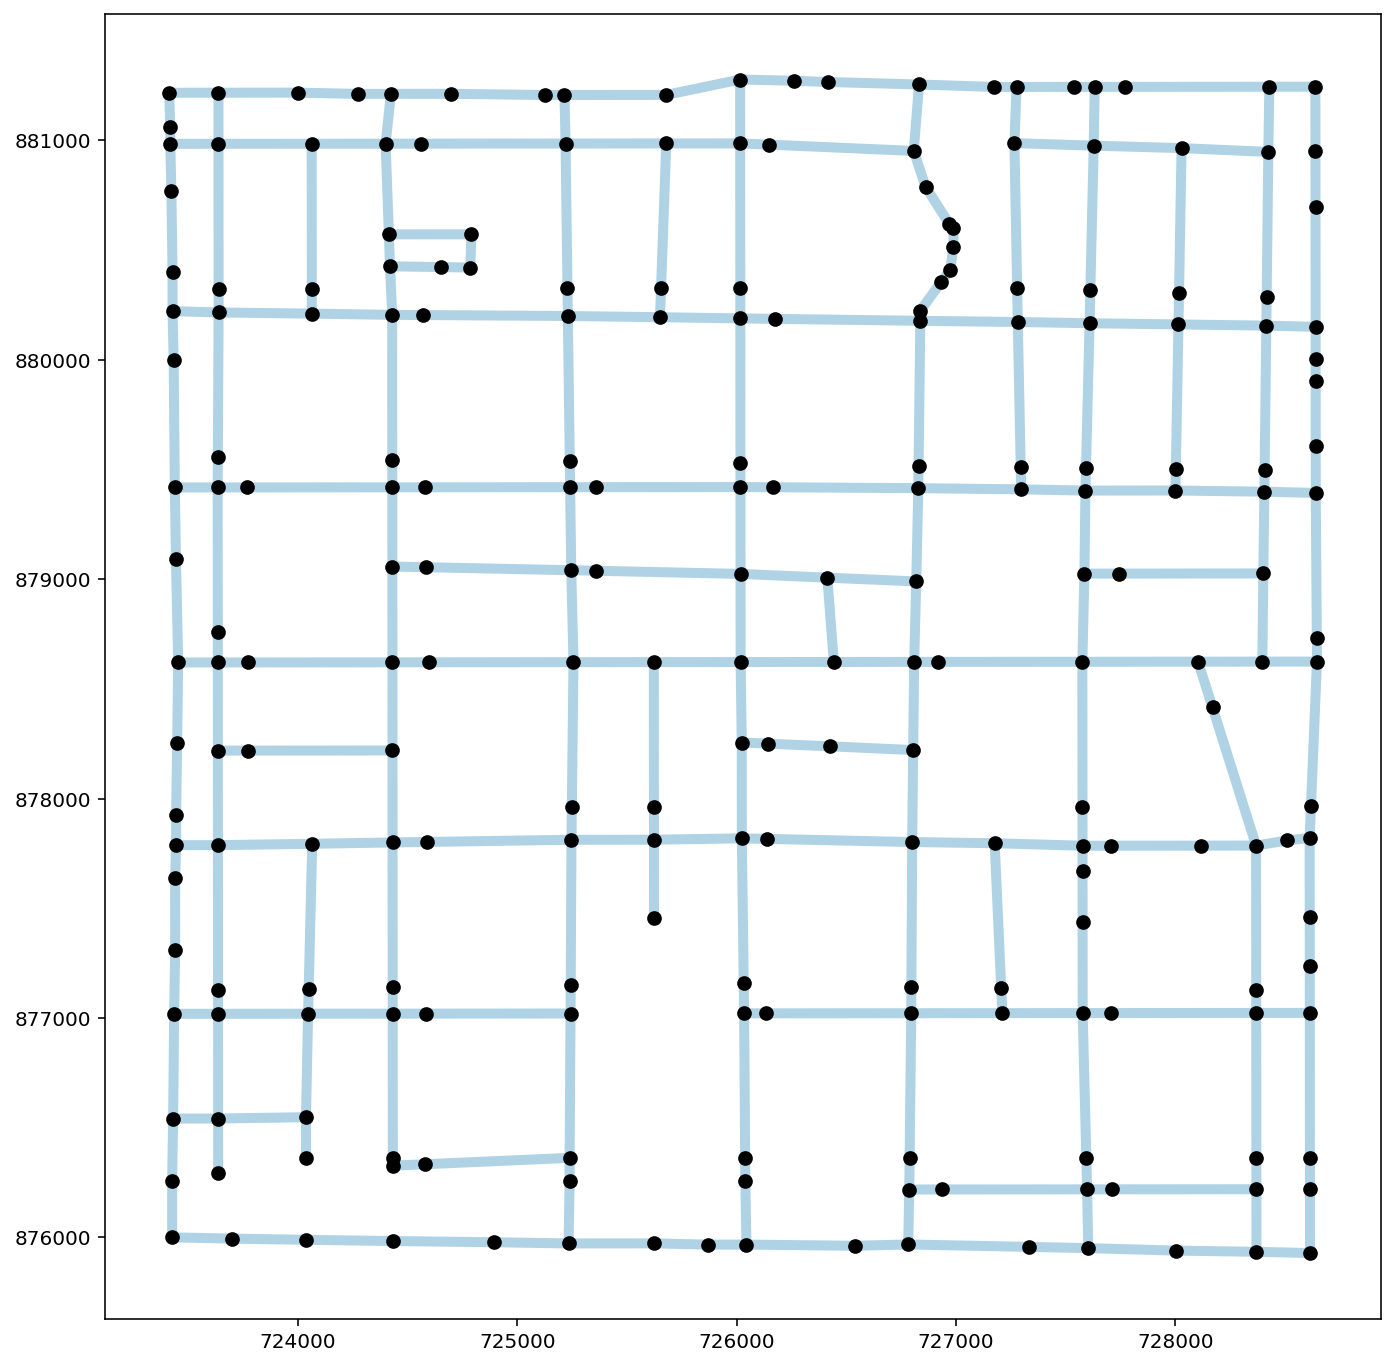

In [25]:
plotter(arcs, vertices, mst_arcs=None, mst_verts=None, label=False)

###### Minimum Spanning Tree

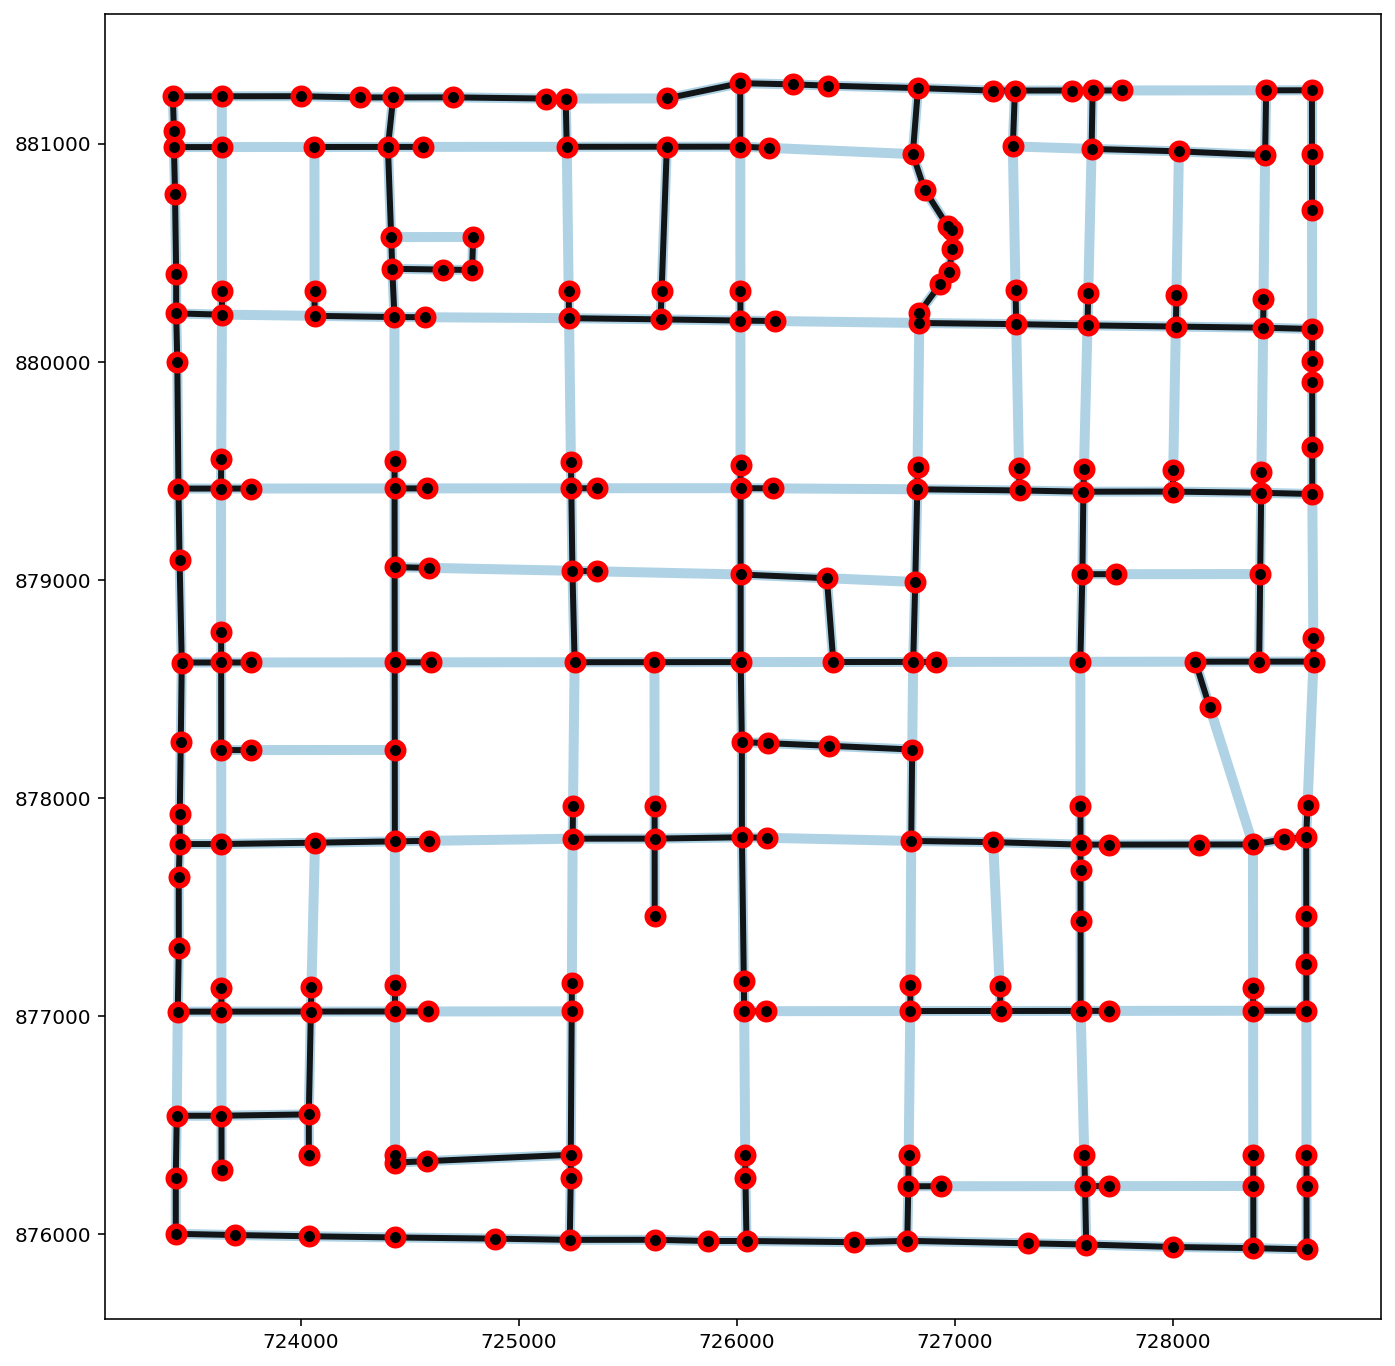

In [26]:
minst_net = spaghetti.spanning_tree(ntw)
mst_verts, mst_arcs = spaghetti.element_as_gdf(minst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts, label=False)

###### Maximum Spanning Tree

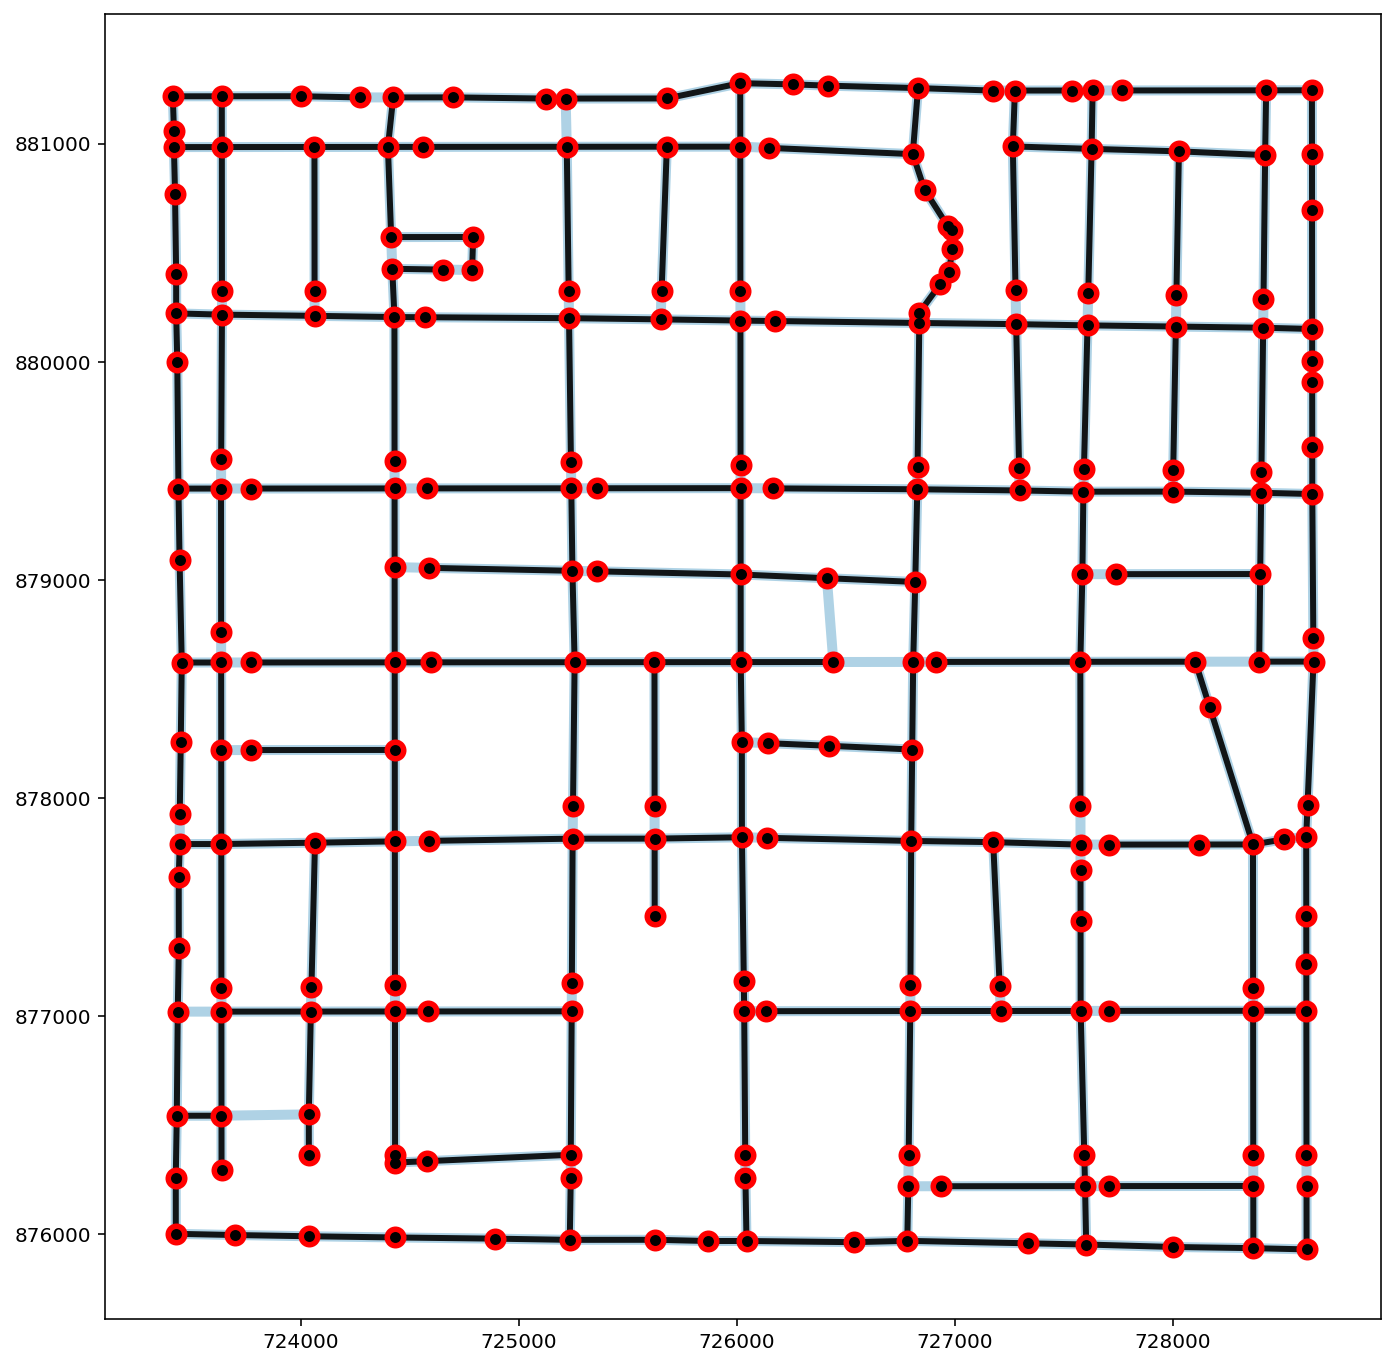

In [27]:
maxst_net = spaghetti.spanning_tree(ntw, maximum=True)
mst_verts, mst_arcs = spaghetti.element_as_gdf(maxst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts, label=False)

--------------